<a href="https://colab.research.google.com/github/Shanks1234567/CSE366LAB/blob/main/Lab_03_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
!unzip drive/MyDrive/"CSE 366"/dataset.zip

Archive:  drive/MyDrive/CSE 366/dataset.zip
   creating: dataset/angry/
  inflating: dataset/angry/02.jpg    
  inflating: dataset/angry/03.jpg    
  inflating: dataset/angry/04.jpg    
  inflating: dataset/angry/05.jpg    
  inflating: dataset/angry/06.jpg    
  inflating: dataset/angry/08.jpg    
  inflating: dataset/angry/09.jpg    
  inflating: dataset/angry/10.jpg    
  inflating: dataset/angry/12.jpg    
  inflating: dataset/angry/16.jpg    
  inflating: dataset/angry/17.jpg    
  inflating: dataset/angry/18.jpg    
  inflating: dataset/angry/19.jpg    
  inflating: dataset/angry/20.jpg    
  inflating: dataset/angry/21.jpg    
  inflating: dataset/angry/22.jpg    
  inflating: dataset/angry/23.jpg    
  inflating: dataset/angry/24.jpg    
  inflating: dataset/angry/25.jpg    
  inflating: dataset/angry/26.jpg    
  inflating: dataset/angry/27.jpg    
  inflating: dataset/angry/28.jpg    
  inflating: dataset/angry/29.jpg    
  inflating: dataset/angry/30.jpg    
  inflating: dat

In [12]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import numpy as np
import cv2

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms
import torchvision.models as models

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns

import time
from collections import OrderedDict

import platform
import psutil

import random
import glob
from tqdm import tqdm

from PIL import Image
from torchvision import transforms
from PIL import ImageOps

from tabulate import tabulate

In [15]:
data_dir = "/content/dataset"  # Updated data directory

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: sad, Count: 100
Class: angry, Count: 100
Class: happy, Count: 100


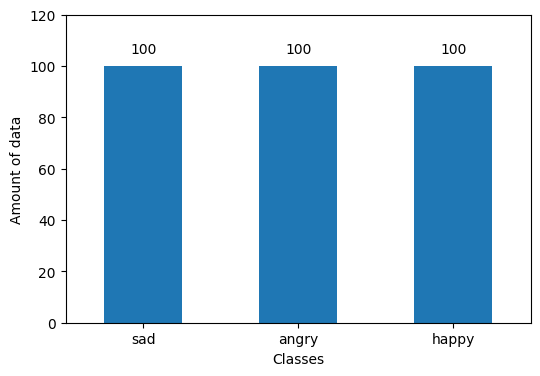

In [16]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(6, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

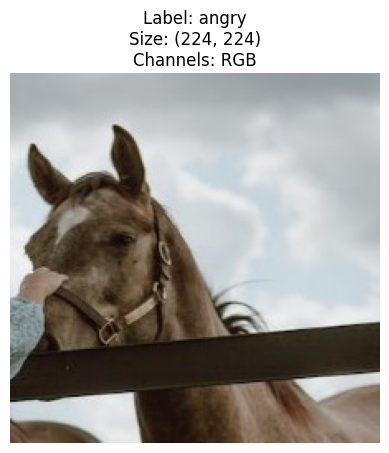

In [17]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)

size = image.size
channels = 'Grayscale' if image.mode == 'L' else 'RGB'
plt.title(f"Label: {label}\nSize: {size}\nChannels: {channels}")
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [18]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
test_dataframe, valid_dataframe = train_test_split(temp_dataframe, test_size=0.5, stratify=temp_dataframe['label'], random_state=42)

In [19]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_dataframe))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  240
Validation Data:  30
Test Data:  30
-------------------------------------------
Total amounts of data in the dataset:  300


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
print(f"Device : {device}")

Device : cpu


In [22]:
save_path_checkpoints = "/content/drive/MyDrive/Colab Notebooks/CNN"
os.makedirs(save_path_checkpoints, exist_ok=True)

In [23]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = {'angry': 0, 'happy': 1, 'sad': 2}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [24]:
batch = 8

def data_transfrom():
    normalize = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    train_dataset = ImageDataset (
        train_dataframe,
        normalize,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_dataframe,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

In [25]:
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 3)  # 3 output classes

        # Dropout layer (to prevent overfitting)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # First convolutional block
        x = self.pool(F.relu(self.conv1(x)))

        # Second convolutional block
        x = self.pool(F.relu(self.conv2(x)))

        # Third convolutional block
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the output for the fully connected layers
        x = x.view(-1, 128 * 28 * 28)

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [26]:
model = CNN_model()
model = model.to(device)

In [27]:
print(model.parameters)

<bound method Module.parameters of CNN_model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)>


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)

In [29]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=10, early_stop_patience=3, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, save_path_checkpoints=save_path_checkpoints)

Epoch 1/10: 100%|██████████| 30/30 [00:59<00:00,  1.97s/it, acc=0.35, loss=1.11]

Training Loss: 1.109 Acc: 0.350


Validation Loss: 1.099 Acc: 0.267
Best model saved at epoch 1 with validation accuracy: 0.267


Epoch 2/10: 100%|██████████| 30/30 [01:03<00:00,  2.11s/it, acc=0.412, loss=1.09]

Training Loss: 1.093 Acc: 0.412


Validation Loss: 1.104 Acc: 0.400
Best model saved at epoch 2 with validation accuracy: 0.400


Epoch 3/10: 100%|██████████| 30/30 [01:00<00:00,  2.03s/it, acc=0.458, loss=1.07]

Training Loss: 1.069 Acc: 0.458


Validation Loss: 1.120 Acc: 0.467
Best model saved at epoch 3 with validation accuracy: 0.467


Epoch 4/10: 100%|██████████| 30/30 [01:00<00:00,  2.02s/it, acc=0.521, loss=1.04]

Training Loss: 1.040 Acc: 0.521


Validation Loss: 1.190 Acc: 0.233
Early stopping criteria met. No improvement in validation accuracy or validation loss for 3 consecutive epochs. Training stopped.


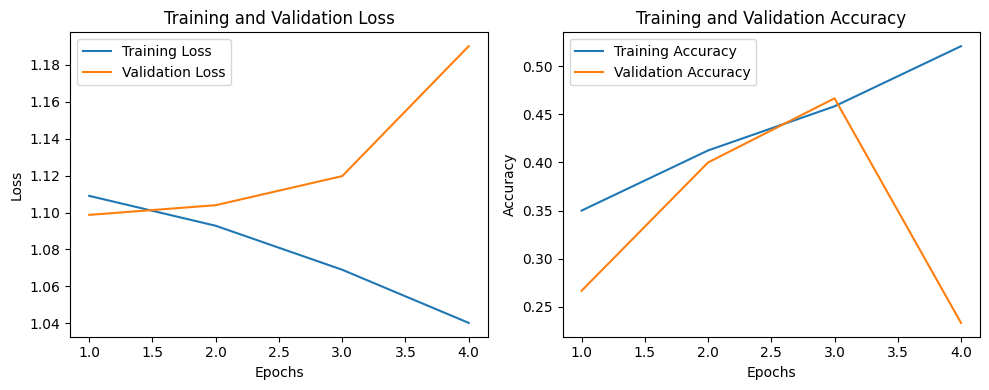

In [30]:
def training_curves(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    epochs = range(1, len(train_loss_history) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_history, label='Training Loss')
    plt.plot(epochs, val_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_history, label='Training Accuracy')
    plt.plot(epochs, val_acc_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

training_curves(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

In [31]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [32]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 3) - Validation Loss: 1.120, Validation Accuracy: 0.467


In [33]:
test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

Test Accuracy: 0.400


In [34]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(3)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, 3)
class_names = {0: "angry", 1: "happy", 2: "sad"}
total_class = len(class_names)
for i in range(total_class):
    print(f"{class_names[i]} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.70      0.50        10
           1       0.00      0.00      0.00        10
           2       0.45      0.50      0.48        10

    accuracy                           0.40        30
   macro avg       0.28      0.40      0.33        30
weighted avg       0.28      0.40      0.33        30

angry Accuracy: 0.700
happy Accuracy: 0.000
sad Accuracy: 0.500


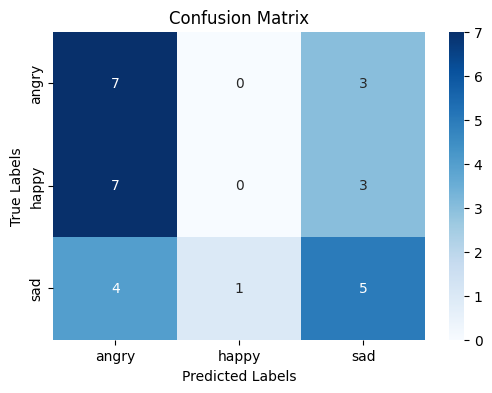

In [35]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(class_names.values()), yticklabels=list(class_names.values()))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()